In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [3]:
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:

# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-9-1/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_10")

data_20_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-8-2/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_20")

[INFO] data\EUROSAT_10 directory exists, skipping download.
[INFO] data\EUROSAT_20 directory exists, skipping download.


In [5]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/EUROSAT_10/train'),
 WindowsPath('data/EUROSAT_20/train'),
 WindowsPath('data/EUROSAT_10/test'))

In [7]:
def create_model(num_classes=10):
  """
  Creates a resnet50 model with transforms and returns them both.
  """ 
  model_weights = torchvision.models.VGG16_Weights.DEFAULT
  model = torchvision.models.vgg16(weights=model_weights)
  transforms = model_weights.transforms()


  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False
  # Adjust the head layer to suit our number of classes
  model.classifier = nn.Sequential(
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  )

  return model, transforms

In [8]:

effnetb2, effnetb2_transforms = create_model(num_classes=10)

In [9]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 288, 288]     [1, 10]              --                   Partial
├─Sequential (features)                  [1, 3, 288, 288]     [1, 512, 9, 9]       --                   False
│    └─Conv2d (0)                        [1, 3, 288, 288]     [1, 64, 288, 288]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 288, 288]    [1, 64, 288, 288]    --                   --
│    └─Conv2d (2)                        [1, 64, 288, 288]    [1, 64, 288, 288]    (36,928)             False
│    └─ReLU (3)                          [1, 64, 288, 288]    [1, 64, 288, 288]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 288, 288]    [1, 64, 144, 144]    --                   --
│    └─Conv2d (5)                        [1, 64, 144, 144]    [1, 128, 144, 144]   (73,856)             False
│    └─ReLU (

In [10]:

# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [11]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn, 
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5477 | train_acc: 0.8550 | test_loss: 0.3263 | test_acc: 0.9081
Epoch: 2 | train_loss: 0.4112 | train_acc: 0.9062 | test_loss: 0.3714 | test_acc: 0.9165
Epoch: 3 | train_loss: 0.3611 | train_acc: 0.9287 | test_loss: 0.3081 | test_acc: 0.9328
Epoch: 4 | train_loss: 0.4026 | train_acc: 0.9321 | test_loss: 0.3009 | test_acc: 0.9310
Epoch: 5 | train_loss: 0.2969 | train_acc: 0.9472 | test_loss: 0.4197 | test_acc: 0.9305
Epoch: 6 | train_loss: 0.3597 | train_acc: 0.9480 | test_loss: 0.4326 | test_acc: 0.9332
Epoch: 7 | train_loss: 0.3178 | train_acc: 0.9541 | test_loss: 0.4278 | test_acc: 0.9368
Epoch: 8 | train_loss: 0.3306 | train_acc: 0.9573 | test_loss: 0.4341 | test_acc: 0.9332
Epoch: 9 | train_loss: 0.2809 | train_acc: 0.9629 | test_loss: 0.4227 | test_acc: 0.9371
Epoch: 10 | train_loss: 0.3352 | train_acc: 0.9625 | test_loss: 0.4526 | test_acc: 0.9358


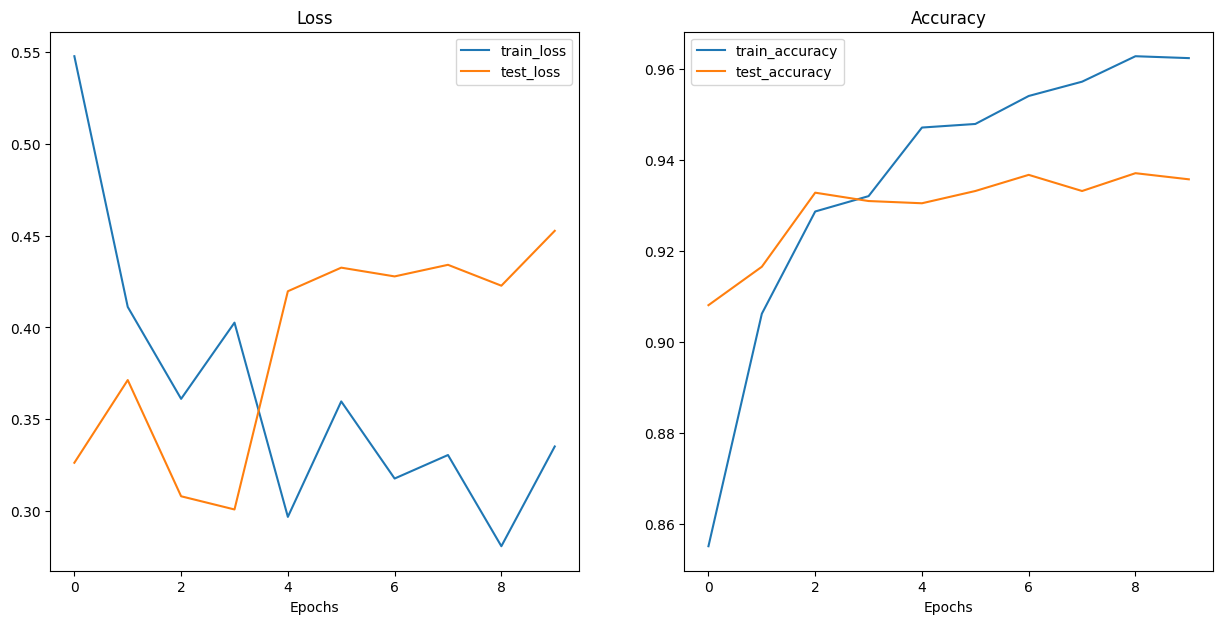

In [12]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [13]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="CNN_VGG16_Data_20_percent.pth")


[INFO] Saving model to: models\CNN_VGG16_Data_20_percent.pth
